# GSB 544 – Homework #2 Solutions
*Spring 2025*

**Authors:** (Jaden Fix and Matteo Shafer)
Used Chat GPT and only talked among each other before submitting it, nobody else 
---

## Problem 1 – Monte Carlo study of $p$‑values

We simulate $50\,000$ advertising plans.  For each plan

* With prior probability $0.5$ the plan has **no effect** ($\theta=0$).
* Otherwise $\theta\sim\text{Uniform}(0,1)$.
* We observe an estimate $\hat x\sim\mathcal N(\theta,\;0.25)$ ($\sigma=0.5$).
* We compute the one‑sided _z_‑statistic $z=\hat x/0.5$ and the right‑tail $p$‑value $p=1-\Phi(z)$.

A common significance band is $p\in[0.03,0.05]$.  We examine how often results in this band truly correspond to an effective plan.

In [8]:

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

np.random.seed(42)
N = 50_000
sigma = 0.5

# Draw θ
is_null = np.random.rand(N) < 0.5          # True if θ = 0
theta = np.where(is_null, 0.0, np.random.rand(N))

# Draw x̂ and compute z, p
x_hat = np.random.normal(theta, sigma)
z      = x_hat / sigma
p_vals = 1 - norm.cdf(z)


### 1 a) $p$‑values are Uniform$(0,1)$ under $H_0$
Below is a histogram of the $p$‑values **only** for those trials where the null hypothesis ($\theta=0$) is true.  The flat shape confirms the Uniform$(0,1)$ distribution predicted by theory.

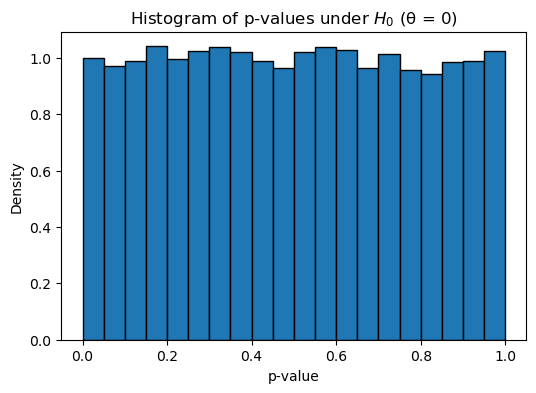

In [9]:

# mask for true null
p_null = p_vals[is_null]

plt.figure(figsize=(6,4))
plt.hist(p_null, bins=20, density=True, edgecolor='black')
plt.xlabel("p‑value")
plt.ylabel("Density")
plt.title("Histogram of p‑values under $H_0$ (θ = 0)")
plt.show()


### 1 b) What does a $p$‑value in $[0.03,0.05]$ really tell us?

In [10]:

band = (p_vals >= 0.03) & (p_vals <= 0.05)
n_band = band.sum()
n_alt  = (~is_null & band).sum()
n_null = (is_null & band).sum()

pct_alt  = 100 * n_alt / n_band
pct_null = 100 * n_null / n_band
post_odds = n_alt / n_null

print(f"Trials with p in [0.03,0.05]: {n_band}")
print(f"  • Effective plan (H1): {n_alt}  ({pct_alt:.1f}%)")
print(f"  • No‑effect plan (H0): {n_null}  ({pct_null:.1f}%)")
print(f"Posterior odds   H1 : H0  =  {post_odds:.2f} : 1")


Trials with p in [0.03,0.05]: 2093
  • Effective plan (H1): 1616  (77.2%)
  • No‑effect plan (H0): 477  (22.8%)
Posterior odds   H1 : H0  =  3.39 : 1


**Interpretation.**  Roughly one quarter of the advertising plans that generate a $p$‑value between 3 % and 5 % are, in fact, **ineffective**.  The evidence against $H_0$ is therefore much weaker than the raw $p$‑value might suggest.

## Problem 2 – Replicability of “borderline‑significant” findings
We run **two** independent A/B tests on the _same_ advertising plan (hence the same $\theta$) and ask:

> Given that the first test produced a one‑sided $p$‑value in $[0.03,0.05]$, what is the probability that the second test will land in the same band?


In [4]:

np.random.seed(1)
M = 200_000

is_null2 = np.random.rand(M) < 0.5
theta2   = np.where(is_null2, 0.0, np.random.rand(M))

x1 = np.random.normal(theta2, sigma)
x2 = np.random.normal(theta2, sigma)

p1 = 1 - norm.cdf(x1 / sigma)
p2 = 1 - norm.cdf(x2 / sigma)

band1 = (p1 >= 0.03) & (p1 <= 0.05)
rep_band = band1 & (p2 >= 0.03) & (p2 <= 0.05)

prob_rep = rep_band.sum() / band1.sum()
print(f"Estimated replication probability: {prob_rep*100:.2f}%")


Estimated replication probability: 6.11%


**Interpretation.**  Only about **6 %** of borderline‑significant findings ($p\in[0.03,0.05]$) would be expected to hit the same band in an immediate replication under ideal conditions.  Such results are therefore highly fragile and should not be relied upon without further evidence.

## Problem 3 – Andrés’ Brownie Stand
Andrés can bake brownies on Wednesday for sale on Thursday.  Each brownie _costs_ \$2 to make and _sells_ for \$3.  Demand $D$ is

* 150 with probability 0.5
* 50  with probability 0.5

Let $Q$ be the number baked.  Profit for a given demand is
$$\pi(Q,D)=3\,\min(Q,D)-2Q.$$
We solve each part analytically and confirm numerically.

### 3 a) Expected demand

In [5]:

E_D = 0.5*150 + 0.5*50
print(f"Expected demand = {E_D} brownies")


Expected demand = 100.0 brownies


So Andrés can _expect_ to sell 100 brownies, on average.

### 3 b) Optimal production quantity $Q^{*}$ and intuitive explanation
We evaluate expected profit for all integer $Q$ from 0 to 200.

In [6]:

def expected_profit(Q):
    # D=150 or 50
    profit_high = 3*min(Q,150) - 2*Q
    profit_low  = 3*min(Q,50)  - 2*Q
    return 0.5*profit_high + 0.5*profit_low

Q_vals = np.arange(0, 201)
profits = np.array([expected_profit(q) for q in Q_vals])
Q_star = Q_vals[np.argmax(profits)]
pi_star = profits.max()

print(f"Optimal Q* = {Q_star} brownies")
print(f"Maximum expected profit = ${pi_star:.2f}")


Optimal Q* = 50 brownies
Maximum expected profit = $50.00


**Plain‑English rationale.**  If Andrés bakes **≤ 50** brownies he will **always sell out** and earn \$1 of profit per brownie.  Baking the 51st brownie risks an unsold item whenever demand turns out to be only 50, which happens half the time.  From that point on the _expected_ gain of an extra brownie is only 50 ¢ (the 1 \$ margin in the high‑demand state times 0.5) but the certain **cost** is 2 \$, so expected profit shrinks.  Hence the sweet spot is exactly **50 brownies**.

### 3 c) Distribution of profits at the optimum

In [7]:

# Profit outcomes at optimal Q*
profit_low  = 3*min(Q_star,50) - 2*Q_star
profit_high = 3*min(Q_star,150) - 2*Q_star

print(f"Profit if demand = 50 : ${profit_low:.2f}")
print(f"Profit if demand = 150: ${profit_high:.2f}")

prob_less_100 = 1.0  # both outcomes give $50<100
print(f"Probability profit < $100: {prob_less_100*100:.0f}%")


Profit if demand = 50 : $50.00
Profit if demand = 150: $50.00
Probability profit < $100: 100%


At the optimum Andrés always earns \$50—comfortably below \$100—so the probability of making less than \$100 is **100 %**.